In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load the data
df = pd.read_csv("C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\hundreds_extracted_data_with_match_stats.csv")
df = df[df['Season'] != 2024 ]
# Display basic information about the dataframe
print(df['Season'].unique())

[2021 2022 2023]


In [7]:
# Check for missing values
print(df.isnull().sum())

# Fill missing values in 'Wicket Type' with 'Not Applicable'
#df['Wicket Type'].fillna('Not Applicable', inplace=True)

# Filter out 'tie' and 'no result' matches
df = df[~df['Match Winner'].isin(['tie', 'no result'])]

print("Shape after filtering:", df.shape)


Date                          0
Match Number                  0
Season                        0
Gender                        0
Innings                       0
Toss Winner                   0
Toss Decision                 0
Match Winner                  0
Venue                         0
Player Team                   0
Team Against                  0
target                        0
Player Name                   0
Number of Runs Scored         0
Number of Balls Faced         0
4s                            0
6s                            0
Strike Rate                   0
Wicket Type                1296
Number of Balls Bowled        0
Number of Runs Conceded       0
Economy                       0
Catches                       0
Run Outs                      0
Wicket Taken                  0
match_id                    110
gender                      110
season                      110
team_scores                 110
inning                      110
dtype: int64
Shape after filtering: (398

In [9]:
# Step 5: Create batsmen_stats
batsmen_stats = df.groupby('Player Name').agg({
    'Number of Runs Scored': 'sum',
    'Number of Balls Faced': 'sum',
    '4s': 'sum',
    '6s': 'sum',
    'Match Number': 'nunique',  # This gives the number of unique matches
    'Gender': 'first'  # This takes the first gender value (assuming it's consistent for each player)
}).reset_index()

batsmen_stats.columns = ['Player Name', 'Runs', 'Balls Faced', '4s', '6s', 'Matches Played', 'Gender']

batsmen_stats['Average'] = batsmen_stats['Runs'] / batsmen_stats['Matches Played']
batsmen_stats['Strike Rate'] = (batsmen_stats['Runs'] / batsmen_stats['Balls Faced']) * 100
batsmen_stats['Boundary %'] = (batsmen_stats['4s'] + batsmen_stats['6s']) / batsmen_stats['Balls Faced'] * 100

# Step 6: Create bowler_stats
bowler_stats = df.groupby('Player Name').agg({
    'Number of Balls Bowled': 'sum',
    'Number of Runs Conceded': 'sum',
    'Wicket Taken': 'sum',
    'Match Number': 'nunique',  # This gives the number of unique matches
    'Gender': 'first'  # This takes the first gender value (assuming it's consistent for each player)
}).reset_index()

bowler_stats.columns = ['Player Name', 'Balls Bowled', 'Runs Conceded', 'Wickets', 'Matches Played', 'Gender']

bowler_stats['Average'] = bowler_stats['Runs Conceded'] / bowler_stats['Wickets'].replace(0, 1)
bowler_stats['Economy'] = (bowler_stats['Runs Conceded'] / (bowler_stats['Balls Bowled'] / 6)).round(2)
bowler_stats['Strike Rate'] = bowler_stats['Balls Bowled'] / bowler_stats['Wickets'].replace(0, 1)

# Print the first few rows of each dataframe to verify
print(batsmen_stats.head())
print('\n')
print(bowler_stats.head())

# Save the updated dataframes
#batsmen_stats.to_csv('batsmen_stats_updated.csv', index=False)
#bowler_stats.to_csv('bowler_stats_updated.csv', index=False)


   Player Name  Runs  Balls Faced  4s  6s  Matches Played  Gender    Average  \
0   A Campbell    97          131   8   0               8  female  12.125000   
1     A Capsey   380          289  52   7              16  female  23.750000   
2  A Cranstone    18           20   2   0               1  female  18.000000   
3  A Griffiths    23           28   1   0              13  female   1.769231   
4    A Hartley     3            5   0   0              17  female   0.176471   

   Strike Rate  Boundary %  
0    74.045802    6.106870  
1   131.487889   20.415225  
2    90.000000   10.000000  
3    82.142857    3.571429  
4    60.000000    0.000000  


   Player Name  Balls Bowled  Runs Conceded  Wickets  Matches Played  Gender  \
0   A Campbell             0              0        0               8  female   
1     A Capsey           270            288       19              16  female   
2  A Cranstone             0              0        0               1  female   
3  A Griffiths         

In [11]:
# Step 7: Create match_stats and team_stats
match_stats = df.groupby(['Season', 'Gender', 'Match Number', 'Player Team']).agg({
    'team_scores': 'first',
    'Number of Runs Conceded': 'sum',
    'Match Winner': 'first'
}).reset_index()

match_stats['Win'] = (match_stats['Player Team'] == match_stats['Match Winner']).astype(int)
match_stats['Total Balls'] = df.groupby(['Season', 'Gender', 'Match Number', 'Player Team'])['Number of Balls Bowled'].sum().values
match_stats['Economy Rate'] = (match_stats['Number of Runs Conceded'] / (match_stats['Total Balls'] / 6)).round(2)

team_stats = match_stats.groupby(['Player Team', 'Season', 'Gender']).agg({
    'team_scores': 'mean',
    'Economy Rate': 'mean',
    'Win': ['mean', 'sum'],  # Add sum for Win Count
    'Match Number': 'count'
}).reset_index()

# Flatten column names
team_stats.columns = ['Team', 'Season', 'Gender', 'Avg Score', 'Avg Economy', 'Win %', 'Win Count', 'Matches Played']

# Round the percentage and average columns
team_stats['Win %'] = (team_stats['Win %'] * 100).round(2)
team_stats['Avg Score'] = team_stats['Avg Score'].round(2)
team_stats['Avg Economy'] = team_stats['Avg Economy'].round(2)

# Ensure Win Count is an integer
team_stats['Win Count'] = team_stats['Win Count'].astype(int)

# Sort the dataframe
team_stats = team_stats.sort_values(['Season', 'Gender', 'Win %'], ascending=[True, True, False])

print(team_stats.head(10))

# team_stats.to_csv('team_stats.csv', index=False)

                      Team  Season  Gender  Avg Score  Avg Economy  Win %  \
30          Southern Brave    2021  female     116.56         6.92  77.78   
24        Oval Invincibles    2021  female     115.11         6.63  66.67   
6            London Spirit    2021  female     116.75         7.41  50.00   
0       Birmingham Phoenix    2021  female     127.22         7.89  44.44   
12    Manchester Originals    2021  female     117.57         7.72  42.86   
18  Northern Superchargers    2021  female     121.43         7.94  42.86   
36           Trent Rockets    2021  female     125.43         7.98  42.86   
42              Welsh Fire    2021  female     115.88         8.43  25.00   
31          Southern Brave    2021    male     138.67         8.40  77.78   
1       Birmingham Phoenix    2021    male     148.67         8.82  66.67   

    Win Count  Matches Played  
30          7               9  
24          6               9  
6           4               8  
0           4           

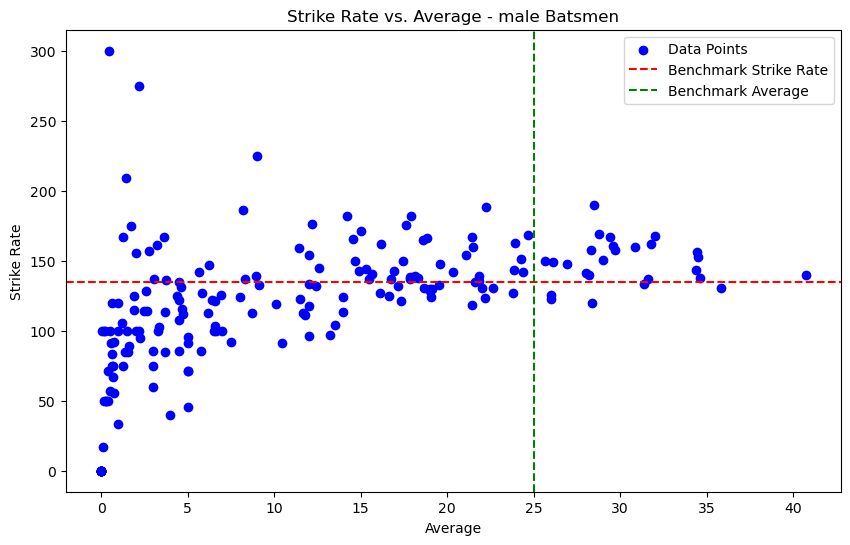

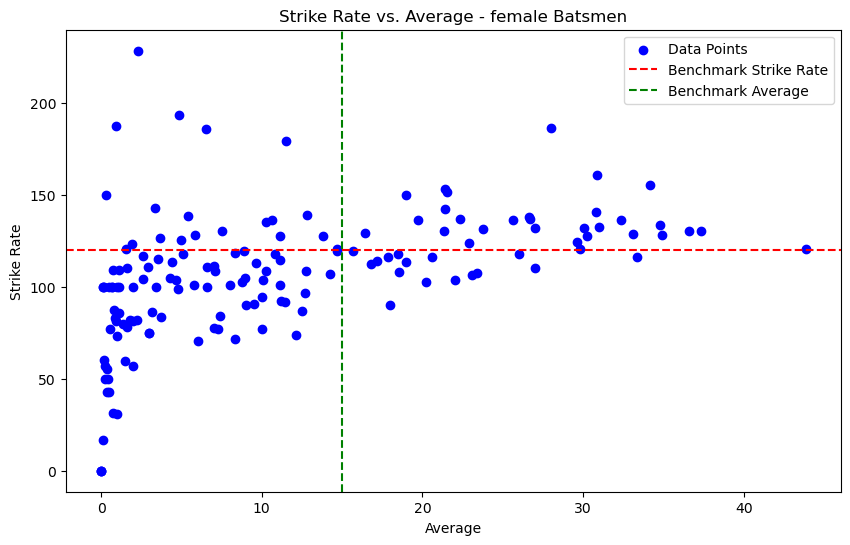

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load the data
df_batsmen = pd.read_csv('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\batsmen_stats_updated.csv')

# Define benchmarks for batsmen
benchmarks = {
    'male': {'strike_rate': 135, 'average': 25},
    'female': {'strike_rate': 120, 'average': 15}
}

# Aggregate data for each player
aggregated_data = df_batsmen.groupby(['Player Name', 'Gender']).agg({
    'Runs': 'sum',
    'Balls Faced': 'sum',
    'Matches Played': 'sum',
    'Average': 'mean',
    'Strike Rate': 'mean'
}).reset_index()

# Calculate additional metrics
aggregated_data['total_runs'] = aggregated_data['Runs']
aggregated_data['total_average'] = aggregated_data['Average']
aggregated_data['aggregated_strike_rate'] = aggregated_data['Strike Rate']

# Drop unnecessary columns
aggregated_data.drop(columns=['Runs', 'Balls Faced', 'Matches Played', 'Average', 'Strike Rate'], inplace=True)

# Calculate residuals for batsmen
def calculate_residuals(data, benchmarks):
    data['residual'] = data.apply(lambda row: 
                                  (row['aggregated_strike_rate'] - benchmarks[row['Gender']]['strike_rate']) + 
                                  (row['total_average'] - benchmarks[row['Gender']]['average']), axis=1)
    return data

# Calculate residuals for the data
aggregated_data = calculate_residuals(aggregated_data, benchmarks)

# Calculate probability scores for batsmen
def calculate_probability_scores(data):
    # Standardize residuals
    mean_residual = data['residual'].mean()
    std_residual = data['residual'].std()
    data['standardized_residual'] = (data['residual'] - mean_residual) / std_residual

    # Calculate probability scores
    data['probability_score'] = norm.cdf(data['standardized_residual'])
    return data

aggregated_data = calculate_probability_scores(aggregated_data)

# Plot for batsmen
def plot_with_smooth_line(data, gender, benchmarks):
    loess = sm.nonparametric.lowess
    averages = data['total_average']
    strike_rates = data['aggregated_strike_rate']

    plt.figure(figsize=(10, 6))
    plt.scatter(averages, strike_rates, label='Data Points', color='blue')
    plt.axhline(y=benchmarks[gender]['strike_rate'], color='red', linestyle='--', label='Benchmark Strike Rate')
    plt.axvline(x=benchmarks[gender]['average'], color='green', linestyle='--', label='Benchmark Average')
    plt.xlabel('Average')
    plt.ylabel('Strike Rate')
    plt.title(f'Strike Rate vs. Average - {gender} Batsmen')
    plt.legend()
    # plt.savefig(f'Strike Rate Vs Average - {gender} Batsmen.png')
    plt.show()
    

male_batsman_data = aggregated_data[aggregated_data['Gender'] == 'male']
female_batsman_data = aggregated_data[aggregated_data['Gender'] == 'female']

plot_with_smooth_line(male_batsman_data, 'male', benchmarks)
plot_with_smooth_line(female_batsman_data, 'female', benchmarks)

# male_batsman_data.to_csv('processed_male_batsman_data.csv', index=False)
# female_batsman_data.to_csv('processed_female_batsman_data.csv', index=False)

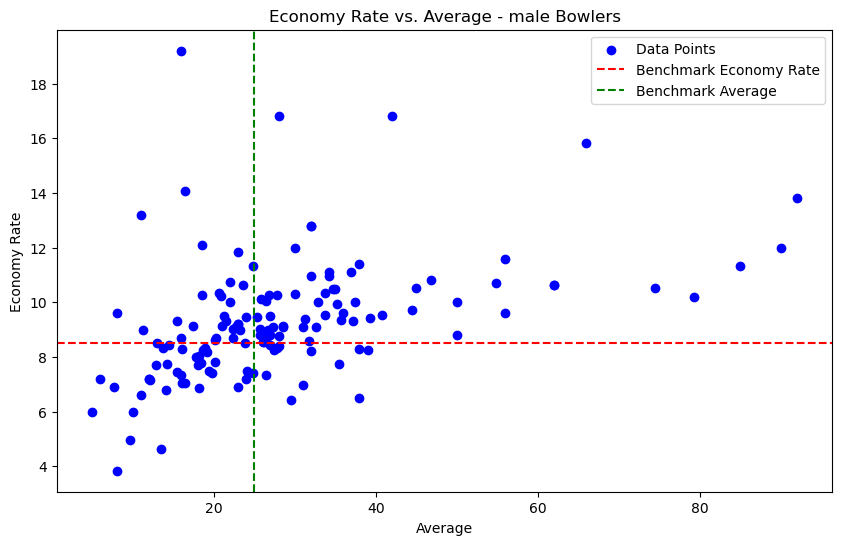

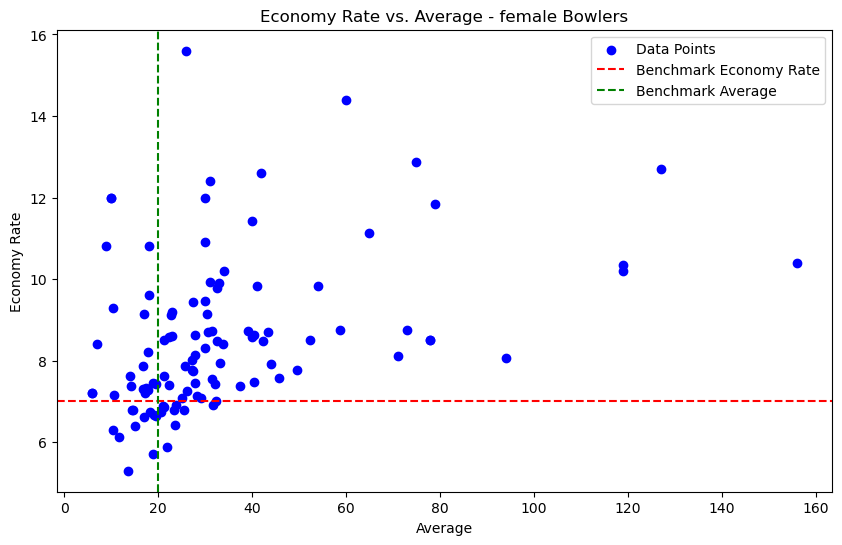

In [15]:
# Define benchmarks for bowlers
benchmarks = {
    'male': {'economy_rate': 8.5, 'average': 25},
    'female': {'economy_rate': 7, 'average': 20}
}

# Load the data
df_bowlers = pd.read_csv('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\bowler_stats_updated.csv')

# Aggregate data for each player
aggregated_data = df_bowlers.groupby(['Player Name', 'Gender']).agg({
    'Balls Bowled': 'sum',
    'Runs Conceded': 'sum',
    'Wickets': 'sum',
    'Matches Played': 'sum',
    'Average': 'mean',
    'Economy': 'mean',
    'Strike Rate': 'mean'
}).reset_index()

# Calculate additional metrics
aggregated_data['total_balls_bowled'] = aggregated_data['Balls Bowled']
aggregated_data['total_runs_conceded'] = aggregated_data['Runs Conceded']
aggregated_data['total_wickets'] = aggregated_data['Wickets']
aggregated_data['total_average'] = aggregated_data['Average']
aggregated_data['aggregated_economy'] = aggregated_data['Economy']

# Drop unnecessary columns
aggregated_data.drop(columns=['Balls Bowled', 'Runs Conceded', 'Wickets', 'Matches Played', 'Average', 'Economy', 'Strike Rate'], inplace=True)

# Calculate residuals for bowlers
def calculate_residuals(data, benchmarks):
    data['residual'] = data.apply(lambda row: 
                                  (benchmarks[row['Gender']]['economy_rate'] - row['aggregated_economy']) + 
                                  (benchmarks[row['Gender']]['average'] - row['total_average']), axis=1)
    return data

# Calculate residuals for the data
aggregated_data = calculate_residuals(aggregated_data, benchmarks)

# Calculate probability scores for bowlers
aggregated_data = calculate_probability_scores(aggregated_data)

# Plot for bowlers
def plot_with_smooth_line(data, gender, benchmarks):
    loess = sm.nonparametric.lowess
    averages = data['total_average']
    economies = data['aggregated_economy']

    plt.figure(figsize=(10, 6))
    plt.scatter(averages, economies, label='Data Points', color='blue')
    plt.axhline(y=benchmarks[gender]['economy_rate'], color='red', linestyle='--', label='Benchmark Economy Rate')
    plt.axvline(x=benchmarks[gender]['average'], color='green', linestyle='--', label='Benchmark Average')
    plt.xlabel('Average')
    plt.ylabel('Economy Rate')
    plt.title(f'Economy Rate vs. Average - {gender} Bowlers')
    plt.legend()
    # plt.savefig(f'Economy Rate vs. Average - {gender} Bowlers.png')
    plt.show()

male_bowler_data = aggregated_data[aggregated_data['Gender'] == 'male']
female_bowler_data = aggregated_data[aggregated_data['Gender'] == 'female']

plot_with_smooth_line(male_bowler_data, 'male', benchmarks)
plot_with_smooth_line(female_bowler_data, 'female', benchmarks)

# male_bowler_data.to_csv('processed_male_bowler_data.csv', index=False)
# female_bowler_data.to_csv('processed_female_bowler_data.csv', index=False)